In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
dataset = pd.read_csv('../secondMMRintData/fullFeature2MMRs.csv')

In [3]:
dataset.head()

,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,MEGNO,MEGNOstd,prelimStable,Stable
0,0,0,0.221502,0.017511,0.002935,0.104761,0.010371,0.300893,0.085965,0.011956,0.086689,0.000000,1.942393,0.032212,True,False
1,1,1,0.190647,0.073477,0.011405,0.033206,0.013957,0.403777,0.005775,0.000461,0.156924,0.000000,22.918673,7.372319,True,False
2,2,2,0.125660,0.034270,0.001506,0.334176,0.088234,0.720557,0.016427,0.008207,0.000000,0.000000,11.884854,3.404385,True,False
3,3,3,0.216684,0.008561,0.002451,0.012940,0.000000,0.235460,0.003955,0.000146,0.013127,0.005636,2.000019,0.001839,True,True
4,4,4,0.024455,NaN,NaN,NaN,NaN,0.034058,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [4]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [5]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 5.62 s, sys: 25.2 ms, total: 5.64 s
Wall time: 5.64 s


In [6]:
dataset

,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,MEGNO,MEGNOstd,prelimStable,Stable,hasnull
0,0,0,0.221502,0.017511,0.002935,0.104761,0.010371,0.300893,0.085965,0.011956,0.086689,0.000000,1.942393,0.032212,True,False,0
1,1,1,0.190647,0.073477,0.011405,0.033206,0.013957,0.403777,0.005775,0.000461,0.156924,0.000000,22.918673,7.372319,True,False,0
2,2,2,0.125660,0.034270,0.001506,0.334176,0.088234,0.720557,0.016427,0.008207,0.000000,0.000000,11.884854,3.404385,True,False,0
3,3,3,0.216684,0.008561,0.002451,0.012940,0.000000,0.235460,0.003955,0.000146,0.013127,0.005636,2.000019,0.001839,True,True,0
4,4,4,0.024455,NaN,NaN,NaN,NaN,0.034058,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133538,3538,138538,0.082222,0.049940,0.016289,0.608276,0.024447,0.664222,0.031330,0.003745,0.000000,0.000000,1.998822,0.003453,True,False,0
133539,3539,138539,0.251338,0.016063,0.002925,0.252494,0.000000,0.272822,0.002159,0.000486,0.016379,0.003788,2.487767,0.188649,True,False,0
133540,3540,138540,0.131799,0.027892,0.001453,0.659321,0.032653,0.366664,0.067070,0.020456,0.005420,0.000000,7.134970,1.931917,True,False,0
133541,3541,138541,0.209454,0.090838,0.010214,1.436775,0.037776,0.395073,0.102280,0.038515,0.039390,0.000000,2.117164,0.088393,True,False,0


In [7]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','twoMMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','twoMMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']
#what is being used to train
features = near + far + megno

MMRdata = ['MMRstrengthnear','twoMMRstrengthnear','MMRstrengthfar','twoMMRstrengthfar']

pnear = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
pfar = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
pmegno = ['MEGNO', 'MEGNOstd']

pfeatures = pnear + pfar + pmegno

In [8]:
dataset

,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,MEGNO,MEGNOstd,prelimStable,Stable,hasnull
0,0,0,0.221502,0.017511,0.002935,0.104761,0.010371,0.300893,0.085965,0.011956,0.086689,0.000000,1.942393,0.032212,True,False,0
1,1,1,0.190647,0.073477,0.011405,0.033206,0.013957,0.403777,0.005775,0.000461,0.156924,0.000000,22.918673,7.372319,True,False,0
2,2,2,0.125660,0.034270,0.001506,0.334176,0.088234,0.720557,0.016427,0.008207,0.000000,0.000000,11.884854,3.404385,True,False,0
3,3,3,0.216684,0.008561,0.002451,0.012940,0.000000,0.235460,0.003955,0.000146,0.013127,0.005636,2.000019,0.001839,True,True,0
4,4,4,0.024455,NaN,NaN,NaN,NaN,0.034058,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133538,3538,138538,0.082222,0.049940,0.016289,0.608276,0.024447,0.664222,0.031330,0.003745,0.000000,0.000000,1.998822,0.003453,True,False,0
133539,3539,138539,0.251338,0.016063,0.002925,0.252494,0.000000,0.272822,0.002159,0.000486,0.016379,0.003788,2.487767,0.188649,True,False,0
133540,3540,138540,0.131799,0.027892,0.001453,0.659321,0.032653,0.366664,0.067070,0.020456,0.005420,0.000000,7.134970,1.931917,True,False,0
133541,3541,138541,0.209454,0.090838,0.010214,1.436775,0.037776,0.395073,0.102280,0.038515,0.039390,0.000000,2.117164,0.088393,True,False,0


add columns for tmax and hasnull manually

In [9]:
dataset['twoMMRstrengthfar'].isna().sum()


14589

Now we do the filtering manually. This is taking only systems with instability times > 1e4 AND no NaNs. Would adjust this for each case. 

We were worried that we were using filter=..., which was filtering out any rows that had any NaNs in them. We wanted to compare results when we don't include that filter, and only filtered for instability_time.

In [10]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [11]:
scrambled = filtData.sample(frac=1)

In [12]:
scrambled = scrambled.reset_index()

In [13]:
scrambled

,level_0,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,MEGNO,MEGNOstd,prelimStable,Stable,hasnull
0,7507,2507,7507,0.172214,0.378002,0.056123,0.014307,0.009207,0.260713,0.054394,0.000099,0.031452,0.000000,14.361004,4.480561,True,False,0
1,123582,3582,123582,0.118551,0.514848,0.000123,0.099394,0.000000,0.693362,0.002389,0.001502,0.000000,0.000000,450.439870,106.547468,True,False,0
2,13113,3113,13113,0.204668,0.104883,0.035611,0.163592,0.022042,0.331467,0.177681,0.032416,0.094225,0.000000,44.104984,8.927008,True,False,0
3,43178,3178,43178,0.068645,0.131724,0.003077,0.171190,0.023660,0.251304,0.002729,0.000234,0.673750,0.000000,2.019812,0.007376,True,False,0
4,122729,2729,122729,0.210820,0.069851,0.015376,0.965003,0.016015,0.592079,0.028640,0.009975,0.515602,0.000000,1.903158,0.025564,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118949,130027,27,135027,0.251693,0.017960,0.003262,0.218751,0.000000,0.326225,0.008129,0.000193,0.064630,0.000000,1.894192,0.089142,True,False,0
118950,126626,1626,126626,0.399278,0.049782,0.024675,0.031756,0.000000,0.587851,0.058242,0.008901,1.235015,0.000000,2.051149,0.034882,True,False,0
118951,40897,897,40897,0.125604,0.022752,0.000487,0.096077,0.013529,0.275815,0.013097,0.004610,0.004427,0.000433,2.026834,0.012220,True,False,0
118952,49393,4393,49393,0.096383,0.049547,0.007209,0.064636,0.024849,0.282200,0.053313,0.016862,0.016414,0.002350,14.754391,2.325471,True,False,0


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

NameError: name 'test' is not defined

In [14]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]

# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [15]:
#features var covers all features
train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

2.3927412741987237

In [16]:
# trainFStab= train.loc[train['Stable']==False]
# trainTStab= train.loc[train['Stable']==True]

In [18]:
realTest = test.loc[test['prelimStable']==True]

In [153]:
realTest

,level_0,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,MEGNO,MEGNOstd,prelimStable,Stable,hasnull
95163,89084,4084,89084,0.095772,0.237303,0.005169,0.124481,0.043354,0.178106,0.161622,0.025064,0.025004,0.010204,221.246296,64.631448,True,False,0
95164,35858,858,35858,0.221295,0.128166,0.001055,0.032267,0.003140,0.300013,0.003606,0.000043,0.049246,0.000000,3.098760,0.430195,True,False,0
95165,54199,4199,54199,0.313633,0.033060,0.002450,0.392549,0.000000,0.624185,0.001692,0.001036,0.061720,0.000000,1.999536,0.000055,True,True,0
95166,72787,2787,72787,0.058175,0.138797,0.000790,0.059268,0.023910,0.179199,0.015611,0.001292,0.006791,0.005797,90.320140,30.027405,True,False,0
95167,17738,2738,17738,0.233116,0.000517,0.000026,0.003642,0.000473,0.260743,0.000400,0.000054,0.001693,0.000000,1.999952,0.000040,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118949,6180,1180,6180,0.112169,0.004149,0.000017,0.006834,0.001851,0.202068,0.002272,0.000170,0.002031,0.000028,1.999767,0.000399,True,True,0
118950,23238,3238,23238,0.256620,0.005186,0.000116,0.014699,0.000000,0.601595,0.004521,0.000488,0.090001,0.000000,1.998327,0.000711,True,True,0
118951,26076,1076,26076,0.132215,0.147427,0.002145,0.333428,0.056789,0.706260,0.000301,0.000526,0.000000,0.000000,2.849458,0.285355,True,False,0
118952,11700,1700,11700,0.059623,0.012959,0.000523,0.315849,0.006912,0.392864,0.007357,0.000032,0.007995,0.000000,1.999155,0.000459,True,True,0


In [154]:
realTest['Stable'].value_counts()[False]

16719

There are more higher EMcrossnear values in the wrong guesses

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
train[features]

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,MEGNO,MEGNOstd
0,0.162639,0.024835,0.000298,1.147552,0.035835,0.307518,0.041700,0.000170,0.516617,0.000000,1.994068,0.005115
1,0.310696,0.103820,0.002332,19.093393,0.000000,0.533948,0.037038,0.020201,0.068376,0.000000,1.913357,0.052258
2,0.208962,0.471804,0.083254,0.178502,0.004840,0.315085,0.092199,0.011173,0.793239,0.000000,19.377435,1.615129
3,0.143753,0.021145,0.000163,0.099148,0.021604,0.159176,0.036522,0.002734,0.110414,0.001246,2.547151,0.189751
4,0.066164,0.141548,0.004064,1.307653,0.082152,0.777677,0.023949,0.000735,0.000000,0.000000,2.000163,0.000074
...,...,...,...,...,...,...,...,...,...,...,...,...
95158,0.210927,0.097461,0.014569,0.043131,0.005010,0.226717,0.043539,0.001241,0.023276,0.010300,135.198913,36.500634
95159,0.131099,0.053484,0.001343,1.283629,0.053620,0.496369,0.082981,0.040736,0.000000,0.000000,2.001441,0.624724
95160,0.062576,0.118152,0.002024,0.056561,0.017675,0.065394,0.028631,0.000392,0.330286,0.008753,4.114020,0.753412
95161,0.129260,0.002058,0.000310,3.153415,0.002633,0.204858,0.004931,0.000265,0.019916,0.001033,1.988011,0.005884


In [191]:
twoModel = XGBClassifier(learning_rate = 0.07, 
                         max_depth = 30, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 250,
                         scale_pos_weight=2.4)




# (learning_rate = 0.03, 
#                          max_depth = 30, 
#                          subsample = 0.9,
#                          min_child_weight = 5,
#                          n_estimators = 300,
#                          scale_pos_weight=2.4)

In [192]:
twoModel.fit(train[features], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [199]:
resPred = twoModel.predict_proba(realTest[features])[:,1]
twoMMRAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
twoMMRacc = accuracy_score(twoModel.predict(realTest[features]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print( accuracy_score(twoModel.predict(realTest[features]), realTest["Stable"]))
#.5% increase in auc

0.9612876766049627
0.9000462359715858


In [ ]:
0.9612876766049627
0.9000462359715858

In [203]:
oneModel = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 20, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         scale_pos_weight=2.4)

In [204]:
oneModel.fit(train[pfeatures], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [205]:
resPred = oneModel.predict_proba(realTest[pfeatures])[:,1]
oneMMRAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
oneMMRacc = accuracy_score(oneModel.predict(realTest[pfeatures]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(oneModel.predict(realTest[pfeatures]), realTest["Stable"]))

0.9538130304779643
0.8856290193770754


In [206]:
#percent decrease in AUC
print()
print(f'decrease in AOC: {((1-oneMMRAUC)-(1-twoMMRAUC))/(1-oneMMRAUC)}')
print(f'decrease in error: {((1-oneMMRacc)-(1-twoMMRacc))/(1-oneMMRacc)}')


decrease in AOC: 0.1618345218218377
decrease in error: 0.12605659683939663


In [141]:
oneModel.get_booster().get_fscore()

{'EMcrossnear': 30422.0,
 'EMfracstdnear': 25914.0,
 'EPstdnear': 28463.0,
 'MMRstrengthnear': 28046.0,
 'EMcrossfar': 26192.0,
 'EMfracstdfar': 26743.0,
 'EPstdfar': 24651.0,
 'MMRstrengthfar': 21874.0,
 'MEGNO': 23276.0,
 'MEGNOstd': 22984.0}

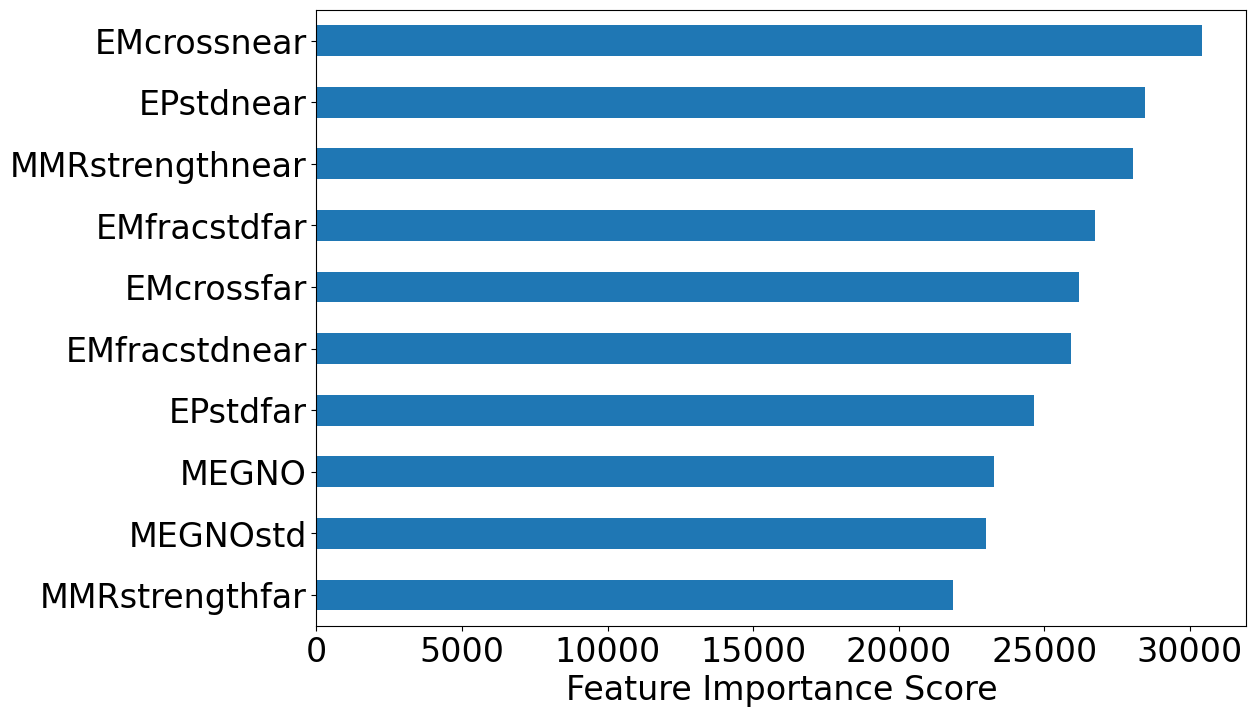

In [142]:
feat_imp = pd.Series(oneModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

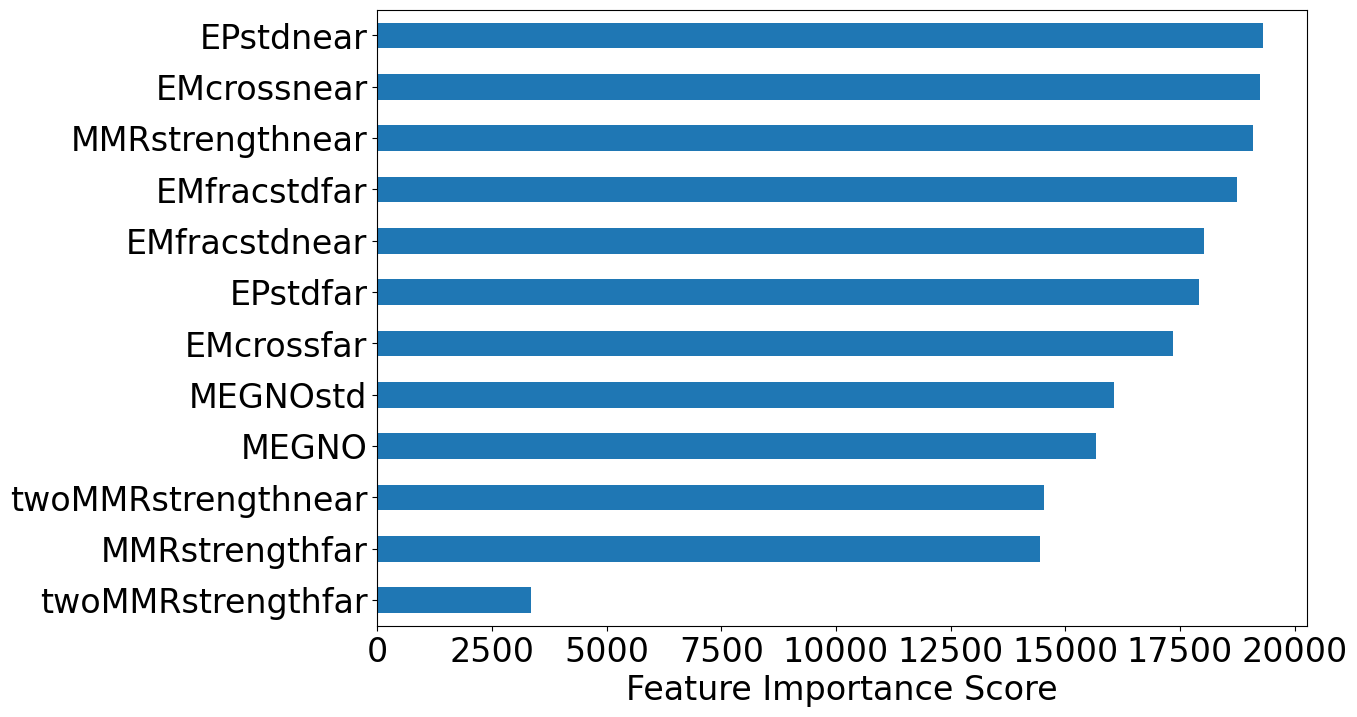

In [197]:
# feature importances
feat_imp = pd.Series(twoModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [200]:
MMRModel = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 25, 
                         subsample = 0.9,
                         min_child_weight = 5,
                         n_estimators = 200,
                         scale_pos_weight=2.4)


In [201]:
MMRModel.fit(train[MMRdata], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [202]:
resPred = MMRModel.predict_proba(realTest[MMRdata])[:,1]
MMRMMRAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
MMRMMRacc = accuracy_score(MMRModel.predict(realTest[MMRdata]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(MMRModel.predict(realTest[MMRdata]), realTest["Stable"]))

0.8583878747429903
0.7823126392333235


In [207]:
twoModel.save_model('SPOCKalt.bin')

In [145]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [69]:
modelNN = Sequential()
modelNN.add(Dense(25, input_shape=(12,), activation = 'relu'))
#modelNN.add(Dense(50, activation='relu'))
modelNN.add(Dense(100, activation='relu'))
modelNN.add(Dense(500, activation='relu'))
modelNN.add(Dense(1500, activation='relu'))
modelNN.add(Dense(3000, activation='relu'))
modelNN.add(Dense(1500, activation='relu'))
modelNN.add(Dense(500, activation='relu'))
modelNN.add(Dense(50, activation='relu'))
modelNN.add(Dense(25, activation='relu'))
modelNN.add(Dense(1, activation='sigmoid'))
modelNN.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['AUC'])

In [131]:
modelNN.fit(train[features], train["Stable"], validation_data=(realTest[features] , realTest['Stable']) ,epochs=1, batch_size=4000, verbose=2)
modelNN.save('2000E4kB.keras')
#modelNN.save_weights("NNtesta.h5")
#print(modelNN.evaluate(test[features], test["Stable"]))
#validation_split=0.2, 

24/24 - 4s - 174ms/step - AUC: 0.9334 - loss: 0.2963 - val_AUC: 0.9349 - val_loss: 0.2950


In [82]:
modelNN.save('2500E4kB.keras')